In [61]:
import h5py
import matplotlib.pyplot as plt

Keys in the file: ['archive', 'artiq_version', 'datasets', 'expid', 'rid', 'run_time', 'start_time']
<KeysViewHDF5 ['fit_signal', 'pmt_counts', 'pmt_counts_avg_thresholded', 'rabi_t']>


Text(0, 0.5, '<z>')

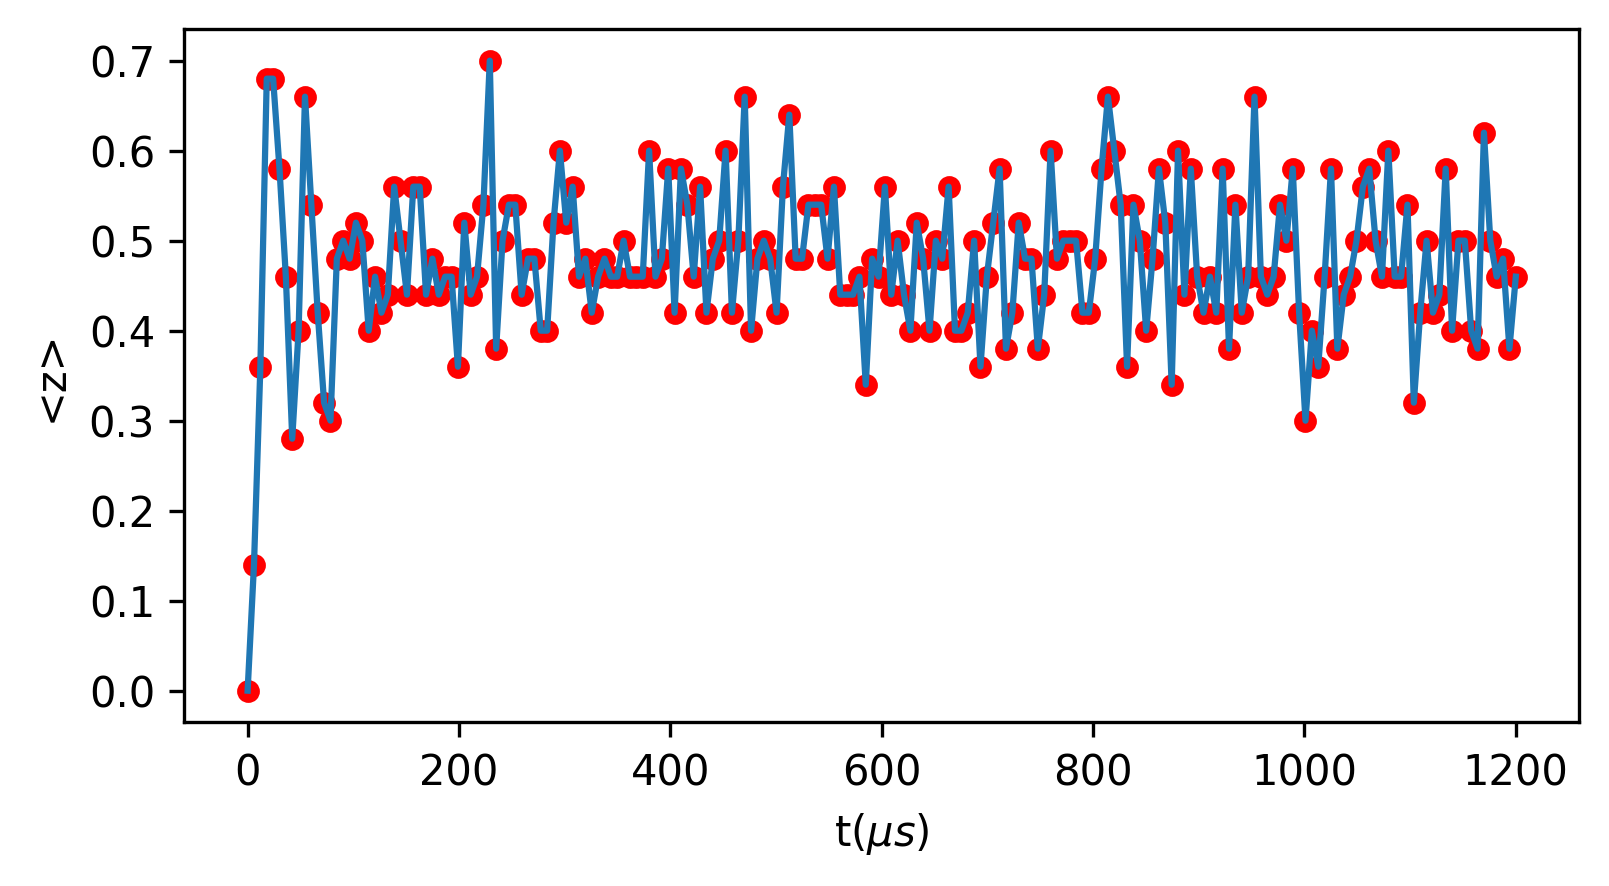

In [62]:
# Path to your .h5 file
file_path = '../results/2024-10-16/20/000027218-A3_VdP_Rabi.h5'

# Open the .h5 file in read mode
with h5py.File(file_path, 'r') as file:
    # Print the names of the groups/datasets in the file
    print("Keys in the file:", list(file.keys()))
    
    # Assuming there's a dataset named 'data' in the file
    # Modify this part according to your file's structure
    data = file['datasets']
    print(data.keys())

    rabi_t= data['rabi_t'][:]
    pmt_count=data['pmt_counts_avg_thresholded'][:]

    # print(data['artiq_version'])

plt.figure(figsize=(6,3),dpi=300)
plt.plot(rabi_t, pmt_count)
plt.scatter(rabi_t, pmt_count,c='red',s=20)
plt.xlabel('${\\rm t}(\mu s)$')
plt.ylabel('<z>')



In [63]:
import numpy as np

def get_freq_component(f: float, t, signal):
    '''
    f: desired frequency
    t: list of time
    signal: list of data at these time
    '''
    kernel=np.exp(-1.0j*f*t*2*np.pi)
    return np.sum(kernel*signal)



In [64]:
eta=0.134
Rabi_freq = 0.0744*0.48#/eta#0.5/70/eta# MHz (pi time ~ 4us)

108.25301318902376
0.02902083333333333
0.812635341995221


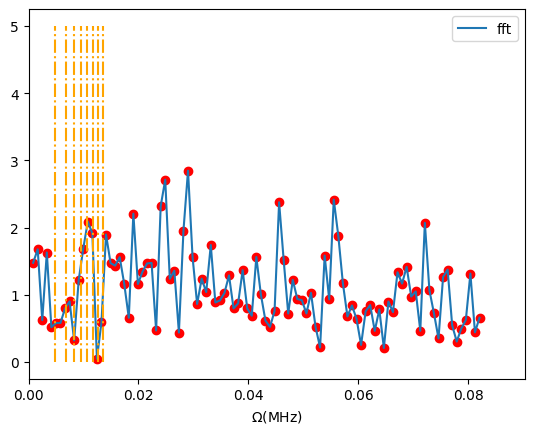

In [65]:
freq=(np.fft.fftshift(np.fft.fftfreq(len(rabi_t), rabi_t[1]-rabi_t[0])))[len(rabi_t)//2+1:]
fft_dt=np.fft.fftshift(np.fft.fft(pmt_count))[len(rabi_t)//2+1:]

freq_fine=np.linspace(freq[0], freq[-1], 1000)
fft_dt2= np.array([get_freq_component(freq_fine[i], rabi_t, pmt_count) for i in range(len(freq_fine))])

plt.plot(freq, np.abs(fft_dt), label='fft')
#plt.plot(freq_fine, np.abs(fft_dt2), label='interpolated fft', c='g')

plt.scatter(freq, np.abs(fft_dt),marker='o',c='r')
for i in range(1,9):
    plt.vlines([np.sqrt(i)*Rabi_freq*eta], ymin=0, ymax=5, linestyles='dashdot',colors='orange')
plt.xlabel('$\\Omega({\\rm MHz})$')
plt.xlim(0,np.max(freq)*1.1)
plt.legend()

print(np.pi/freq[np.argmax(np.abs(fft_dt))])
print(freq[np.argmax(np.abs(fft_dt))])
print(freq[np.argmax(np.abs(fft_dt))]/Rabi_freq)

In [66]:
print(Rabi_freq*eta)

0.004785408


[0.0, np.float64(3.7195095994723952), np.float64(1.2355840755277778), np.float64(0.357054473288721), np.float64(3.852959155413417), np.float64(2.7359527907269348), np.float64(1.3946567493964142), np.float64(1.1924648585264643), np.float64(2.6428812923882266), np.float64(1.3016869867202872), np.float64(1.0076129015549182), np.float64(0.6502835942804454)]


Text(0, 0.5, '<z>')

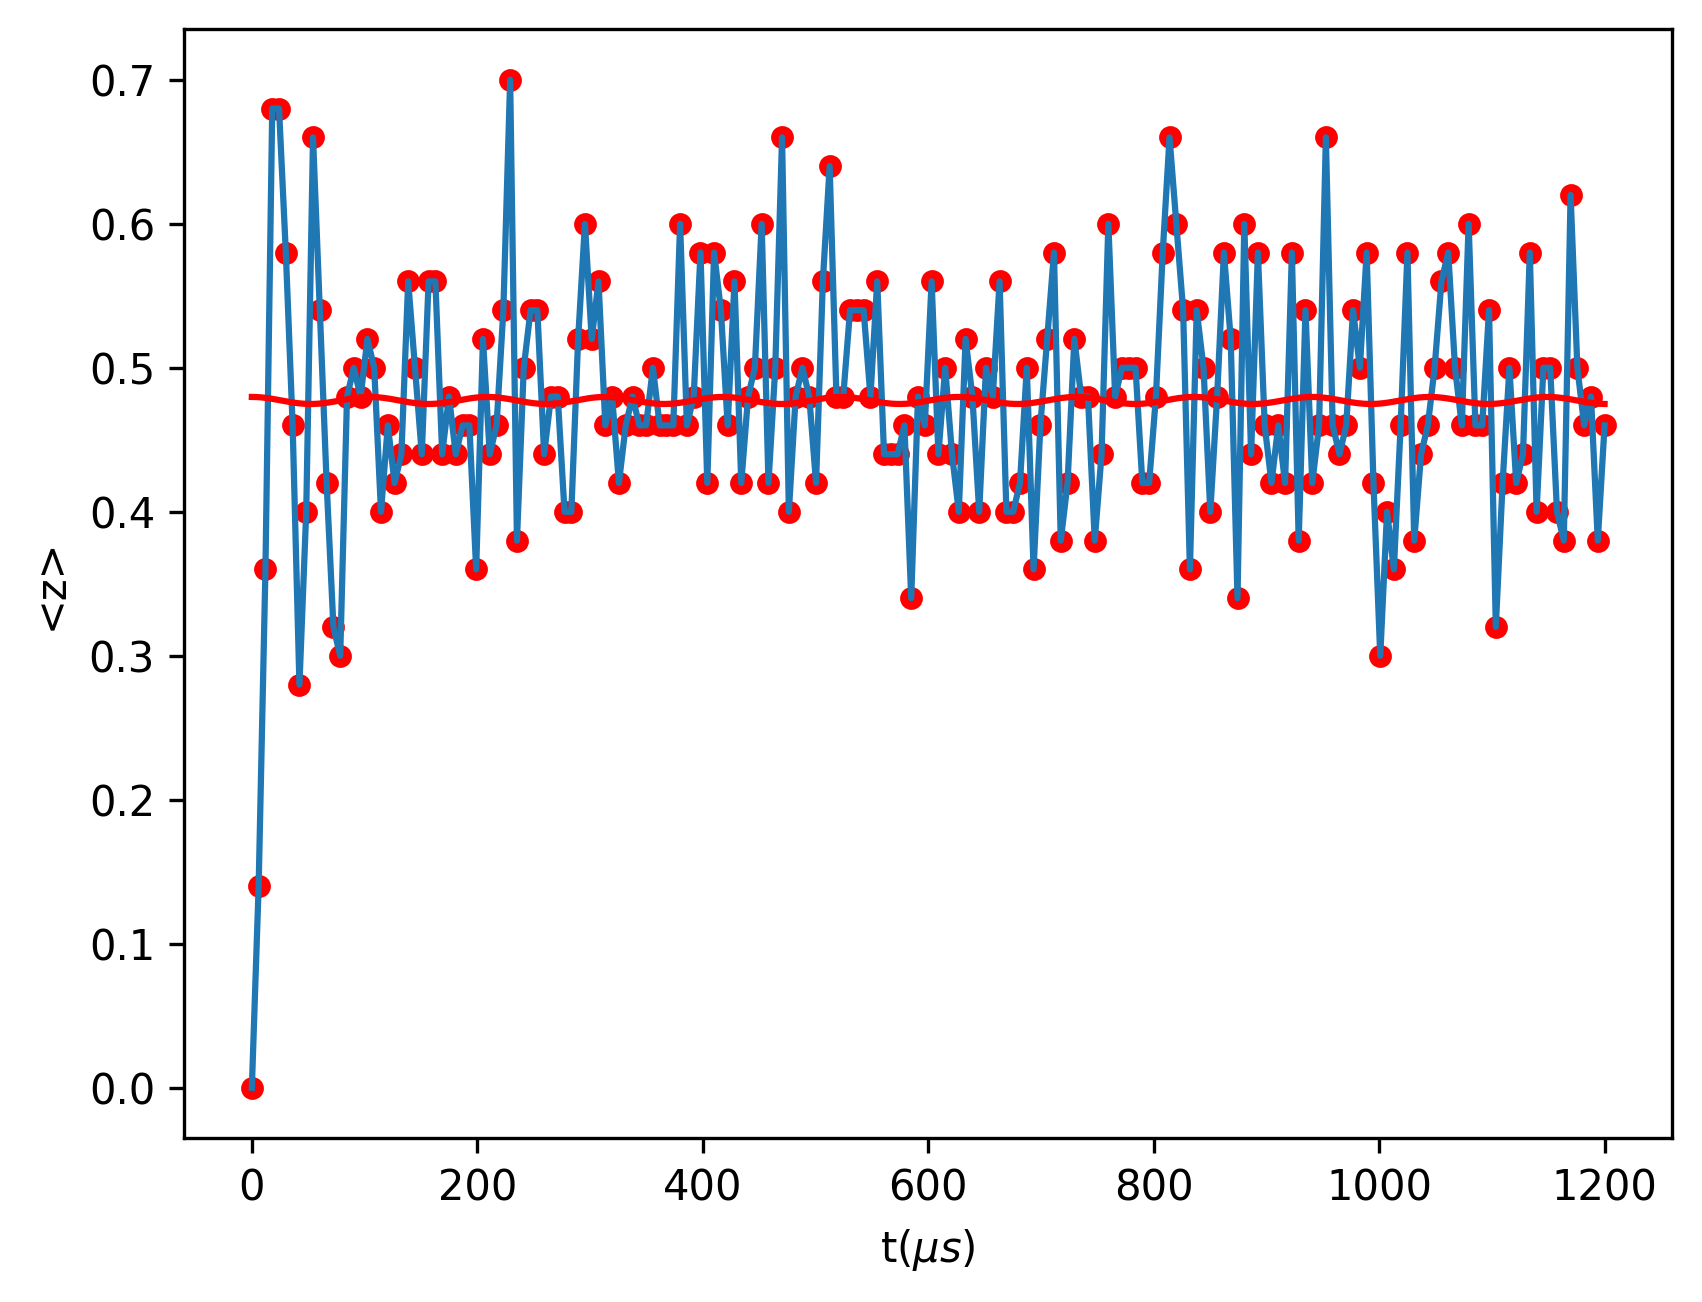

In [67]:
from scipy.optimize import curve_fit


order=12
def rabi(t, *amp):
    sum = amp[0]
    for i in range(1, order):
        sum += amp[i] * np.cos(2*np.pi*t*Rabi_freq*eta*np.sqrt(i))
    return sum

bsb_rabi_freq=[Rabi_freq*eta* np.sqrt(i) for i in range(1,order)]

initial_guess=[0.]+[np.abs(get_freq_component(bsb_rabi_freq[i-1], rabi_t, pmt_count)) for i in range(1,order)]
print(initial_guess)

# Fit the model to the data
popt, pcov = curve_fit(lambda t, *params: rabi(t, *params), 
                       rabi_t, 
                       pmt_count, 
                       p0=initial_guess,
                       bounds=([0]*len(initial_guess), [100]*len(initial_guess))
                       )


plt.figure(dpi=300)
plt.plot(rabi_t, pmt_count)

t_fine=np.linspace(rabi_t[0],rabi_t[-1],10*len(rabi_t))

plt.plot(t_fine, rabi(t_fine, *popt), label='Fitted curve', color='red')

plt.scatter(rabi_t, pmt_count,c='red',s=20)
plt.xlabel('${\\rm t}(\mu s)$')
plt.ylabel('<z>')


Text(0, 0.5, '$\\rho_{nn}$')

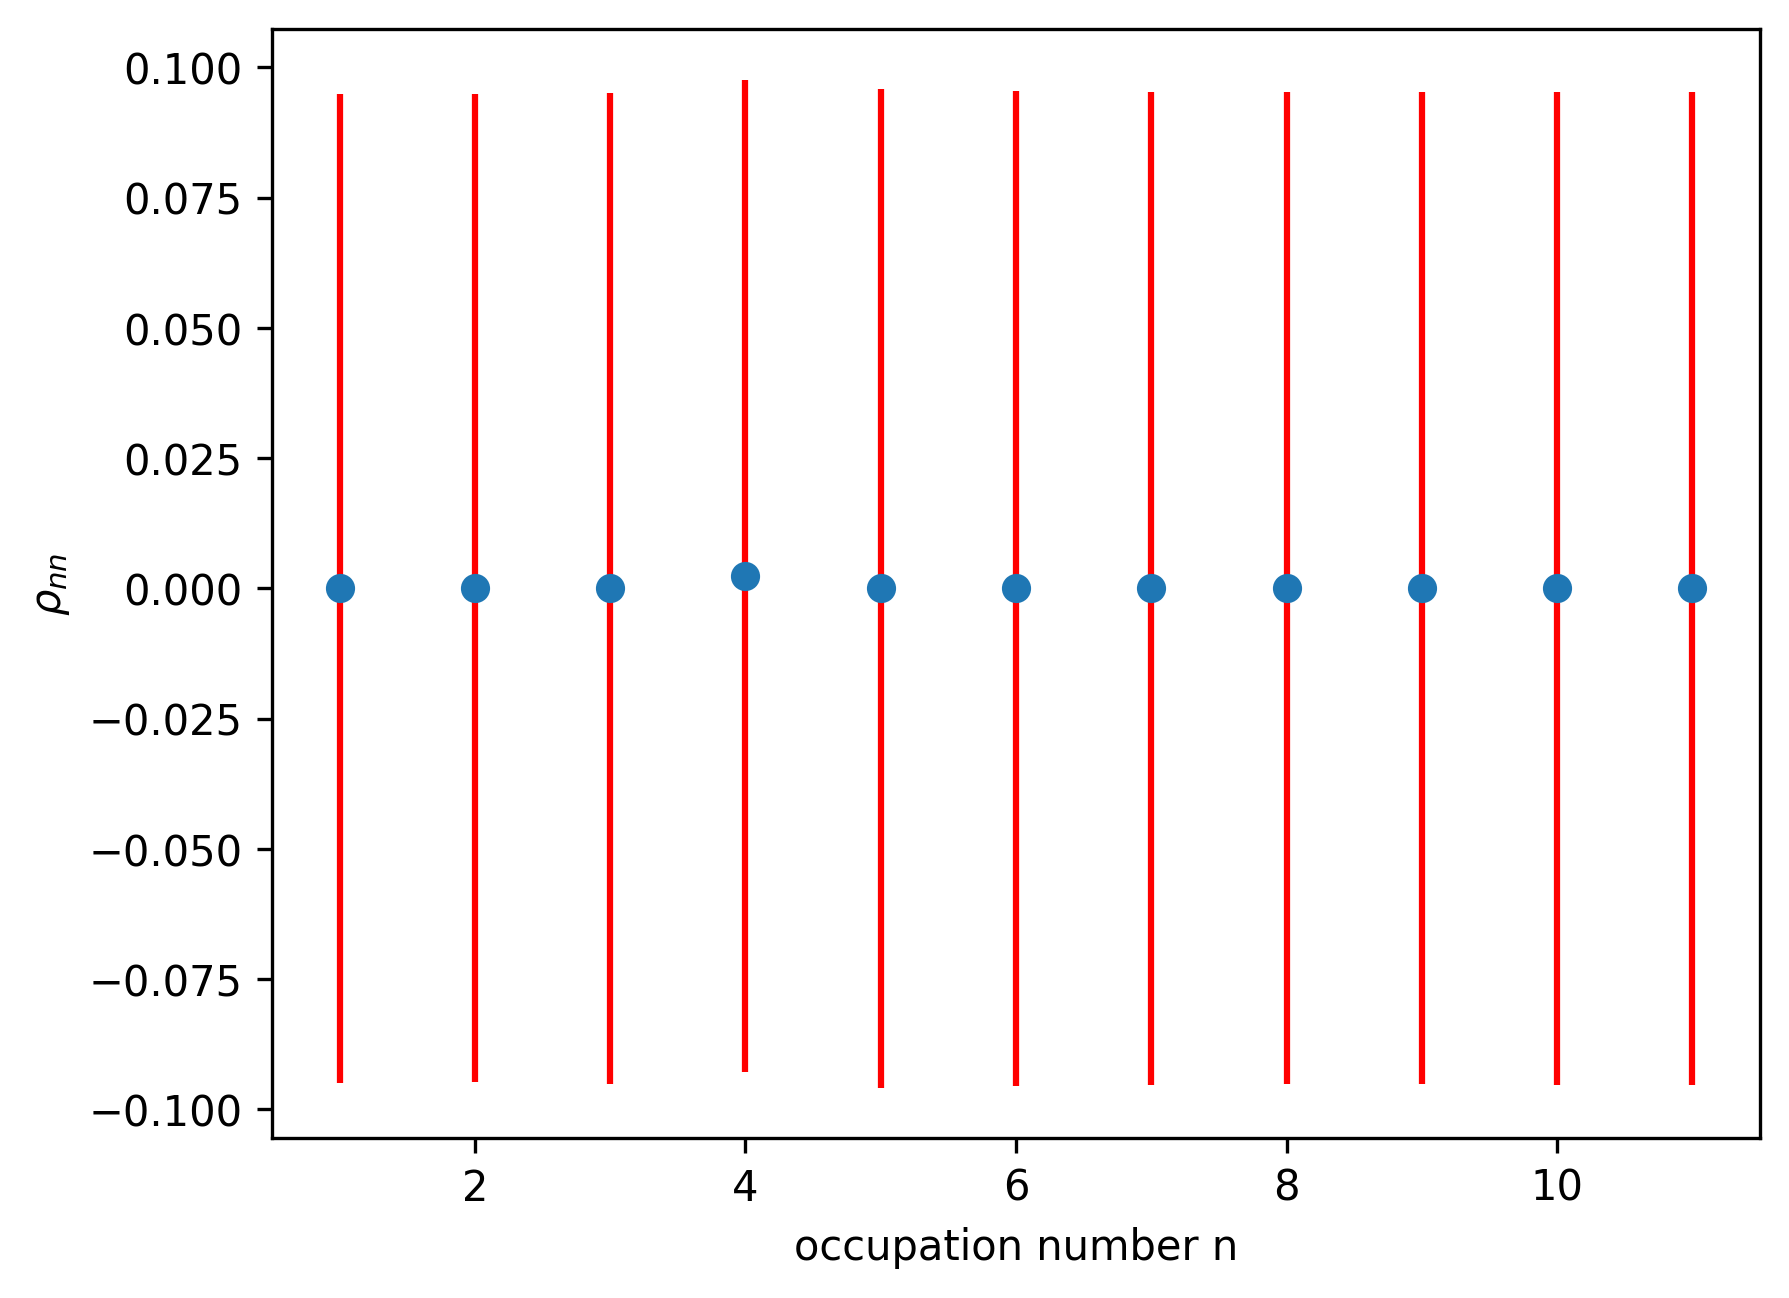

In [68]:
plt.figure(dpi=300)
plt.errorbar(x=range(1,order), y=popt[1:],  yerr=np.sqrt(np.sqrt(np.diag(pcov)[1:])), ecolor='red', fmt='o')
plt.xlabel('occupation number n')
plt.ylabel('$\\rho_{nn}$')